In [2]:
# https://huggingface.co/intfloat/multilingual-e5-large/tree/main#/
import os
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch.nn.functional as F

import numpy as np
from torch import Tensor
from transformers import AutoTokenizer, AutoModel




# 将“query：”和“passage：”对非对称任务相应地使用，例如开放式QA中的段落检索、临时信息检索。
# 对称任务使用“query：”前缀，例如语义相似性、双文本挖掘、释义检索。
# 如果要将嵌入用作特征，请使用“query：”前缀，例如线性探测分类、聚类。
# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = [
    # '先生',"男人","父亲",
#  '女士',"女人", "母亲 "


    '先生',"男人","父亲","男","帅哥","小伙",
 '女士',"女人", "母亲 ","女","美女","姑娘"
# "男孩","爸爸","皇帝","父亲","爷爷","孙子","新郎","丈夫","男人","侄子","王子","儿子","继父","叔叔", 40
# "女孩","妈妈","皇后","母亲","奶奶","孙女","新娘","妻子","女人","侄女","公主","女儿","继母","阿姨"
]


tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
# batch_dict.keys()  dict_keys(['input_ids', 'attention_mask'])
# batch_dict['input_ids'].shape  torch.Size([46, 5])
# batch_dict['attention_mask'].shape  # torch.Size([46, 5])
# tensor([[     0,      6,  72853,      2,      1],
#         [     0,      6,  49790,      2,      1],
#         [     0,      6,  35023,      2,      1],
#         [     0,      6, 180883,      2,      1],
# batch_dict['attention_mask']
# tensor([[1, 1, 1, 1, 0],
#         [1, 1, 1, 1, 0],

outputs = model(**batch_dict)

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)  #torch.Size([40, 1024])

#保存 embeddings
np.save('embeddings.npy', embeddings.cpu().detach().numpy())

mode: Diff Dist
tensor([[ 0.0071, -0.0136, -0.0151,  ..., -0.0295, -0.0105, -0.0319],
        [-0.0210, -0.0276,  0.0128,  ..., -0.0223,  0.0145, -0.0308],
        [ 0.0064, -0.0464,  0.0155,  ..., -0.0078,  0.0085,  0.0063],
        ...,
        [-0.0048,  0.0216, -0.0163,  ..., -0.0089,  0.0193, -0.0207],
        [-0.0227,  0.0185, -0.0005,  ..., -0.0175, -0.0011, -0.0170],
        [-0.0185,  0.0184, -0.0079,  ..., -0.0019, -0.0193, -0.0165]])
compute diff


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:00<00:00, 326.13it/s]

compute out


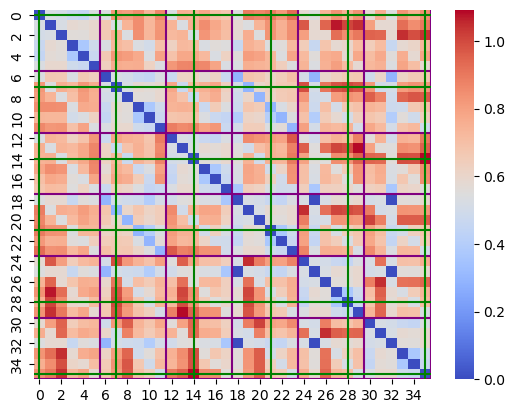

[0.0, 0.5247144103050232, 0.5056219100952148, 0.46674424409866333, 0.44852909445762634, 0.5331256985664368, 0.5359764099121094, 0.8079113960266113, 0.8520140051841736, 0.73405921459198, 0.8618661761283875, 0.5319694876670837, 0.7528411149978638, 0.7814306616783142, 0.7010118961334229, 0.6751538515090942, 0.5382207036018372, 0.8887879848480225, 0.8671244978904724, 0.8201295733451843, 0.9279769062995911, 0.5831547975540161, 0.5382207036018372, 0.7384642362594604, 0.8371155858039856, 0.8364306092262268, 0.582035481929779, 0.7629314661026001, 0.5382207036018372, 0.8332531452178955, 0.7577304244041443, 0.5247144103050232, 0.0, 0.5234647989273071, 0.5839950442314148, 0.5674850940704346, 0.5896061658859253, 0.6637028455734253, 0.5359764099121094, 0.7409374117851257, 0.8526625037193298, 0.7332185506820679, 0.8271222710609436, 0.7415280342102051, 0.5319695472717285, 0.7530770897865295, 0.8516930341720581, 0.7770621180534363, 0.7146971821784973, 0.5831547975540161, 0.5382207036018372, 0.73846423

In [3]:
# 读取 
import Hlib
import numpy as np
import torch
embeddings = np.load('embeddings.npy')
# 转为 tensor
embeddings = torch.tensor(embeddings)


for i,j in Hlib.vector_modes.items():
    for ii,jj in Hlib.diff_modes.items():
        if i== "Cross" and ii == "JaccardSimilarity":
            continue
        out,nonSample,trSample = Hlib.plt_seaborn(embeddings,i,ii)
        print(nonSample)
        print(trSample)
        a,b = Hlib.find_ordered_positions(nonSample, trSample)
        print(a,b)




In [6]:
def Dist(v1, v2, p=2, Abso=True):
    temp = v1 - v2
    if Abso:
        temp = torch.abs(temp)
    return torch.sum(temp ** p) ** (1/p)

for i1 in range(0,6):
    for i2 in range(0,6):
        for i3 in range(0,6):
            for i4 in range(0,6):
                    a = embeddings[i1]
                    b = embeddings[i2+6]
                    s1 = a - b
                    a = embeddings[i3]
                    b = embeddings[i4+6]
                    s2 = a - b
                    print(i1,i2,i3,i4,Dist(s1,s2))



# a = embeddings[4]
# b = embeddings[1+6]

# s1 = a - b

# a = embeddings[3]
# b = embeddings[6]

# s2 = a - b

# def Dist(v1, v2, p=2, Abso=True):
#     temp = v1 - v2
#     if Abso:
#         temp = torch.abs(temp)
#     return torch.sum(temp ** p) ** (1/p)

# print(Dist(s1,s2))


0 0 0 0 tensor(0.)
0 0 0 1 tensor(0.3670)
0 0 0 2 tensor(0.4902)
0 0 0 3 tensor(0.3672)
0 0 0 4 tensor(0.4681)
0 0 0 5 tensor(0.4574)
0 0 1 0 tensor(0.5360)
0 0 1 1 tensor(0.5015)
0 0 1 2 tensor(0.6914)
0 0 1 3 tensor(0.5729)
0 0 1 4 tensor(0.6755)
0 0 1 5 tensor(0.6708)
0 0 2 0 tensor(0.5320)
0 0 2 1 tensor(0.5614)
0 0 2 2 tensor(0.5496)
0 0 2 3 tensor(0.5981)
0 0 2 4 tensor(0.6772)
0 0 2 5 tensor(0.6551)
0 0 3 0 tensor(0.5382)
0 0 3 1 tensor(0.5578)
0 0 3 2 tensor(0.7226)
0 0 3 3 tensor(0.5359)
0 0 3 4 tensor(0.6970)
0 0 3 5 tensor(0.6684)
0 0 4 0 tensor(0.5832)
0 0 4 1 tensor(0.5993)
0 0 4 2 tensor(0.7161)
0 0 4 3 tensor(0.6280)
0 0 4 4 tensor(0.5932)
0 0 4 5 tensor(0.6218)
0 0 5 0 tensor(0.5820)
0 0 5 1 tensor(0.6082)
0 0 5 2 tensor(0.7321)
0 0 5 3 tensor(0.6332)
0 0 5 4 tensor(0.6970)
0 0 5 5 tensor(0.6475)
0 1 0 0 tensor(0.)
0 1 0 1 tensor(0.3670)
0 1 0 2 tensor(0.4902)
0 1 0 3 tensor(0.3672)
0 1 0 4 tensor(0.4681)
0 1 0 5 tensor(0.4574)
0 1 1 0 tensor(0.5360)
0 1 1 1 tensor(0.50